# Reliability Analysis

Analyzing trends in model performance across different categories (people/time/modalities)

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload, import_module
import sys
from sklearn.metrics import roc_curve


In [2]:
sys.path.insert(0, '../code/')
import reliability_analysis
import reliability_data_prep

## Upload features

In [3]:
reload(reliability_data_prep)

# Open
lifesense_df, lifesense_features = reliability_data_prep.upload_lifesense_data()

Total IDs 938
IDs kept 650


# Demographic summary

In [4]:
lifesense_group_cols =[
        'age',
        'demo_gender',
        'demo_race',
        'demo_fam_income',
        'demo_health_insurance',
        'routine_slabels02',
    ]

In [5]:
# Train/test information
reload(reliability_data_prep)

lifesense_demo_summary_df = reliability_data_prep.get_data_stats(
    df=lifesense_df, demo_cols=lifesense_group_cols)

In [6]:
lifesense_demo_summary_df

,num_samples,num_ids,%
Entire study,3900,650,None
Class Balance (%),None,None,46
age: 18 to 25,360,60,9
age: 25 to 34,1086,181,28
age: 35 to 44,1008,168,26
age: 45 to 54,810,135,21
age: 55 to 64,486,81,12
age: 65 to 74,132,22,3
age: 75 to 84,18,3,0
demo_gender: Female,2892,482,74


# Upload Prediction Results

## Setup dictionaries

In [7]:
lifesense_order = {
    'Entire study': ['Entire study'],
    'age': [
        '18 to 25', '25 to 34', '35 to 44', '45 to 54', '55 to 64', 
        '65 to 74', '75 to 84', 'Greater than 85'], #, 'Not answered'],
    'demo_gender': ['Female', 'Male'],
    'demo_race': [
        'White', 'Black/African American', 'Asian/Asian American', 'More than one race', 
       'Other', 'Prefer not to answer'], 
    'demo_race_binary': [
        'White', 'Non-White'], 
    'routine_slabels02': [
        'Employed', 'Unemployed', 'Disability', 'Retired' ,
        'Other', 'Prefer not to answer'], 
    'work_schd': [
        'Fixed work schedule', 'Varied work schedule',
       'Left blank', 'Prefer not to answer'], 
    'slabels04a': [
        'Full-time student', 'Part-time student',
       'Left blank', 'Prefer not to answer'],
    'demo_fam_income': [
        '<20,000', '20,000 to 39,999', '40,000 to 59,999', 
        '60,000 to 99,999', '100,000+',
        "Don't know/not answered"],
    'demo_health_insurance': ["Insured", "Uninsured",
        "Don't know", "Prefer not to answer"],
    'outcome_index': ['1', '2', '3', '4', '5', '6'],
}

group_map = {
    'routine_slabels02': 'Employment',
    "work_schd": "Work Schedule",
    'slabels03b': "Workplace",
    'slabels03c': 'Days Working from Home',
    'slabels03d': 'Travel from Primary Workplace',
    'slabels04': 'Is a Student?',
    'slabels04a': 'Type of student',
    'demo_health_insurance': 'Health Insurance Status',
    'demo_gender': 'Sex at Birth',
    'demo_fam_income': 'Household Income',
    'demo_personal_income': 'Personal Income',
    'age': 'Age',
    'demo_race': 'Race',
}

lifesense_features_dict = {
    'location_entropy': 'Location Entropy',
    'location_norm_entropy': 'Location Normalized Entropy',
    'location_log_var': 'Location Variance',
    'location_log_pgram': 'Circadian Movement',
    'location_log_num_clusters': 'Number of Locations',
    'location_log_home_stay': '% Time at Home',
    'location_log_transition_time': '% Location Data in Transition',
    'screen-state_sleep_onset_mean_daily': 'Sleep Onset',
    'screen-state_log_sleep_duration_mean_daily': 'Sleep Duration',
    'screen-state_log_sleep_duration_std_daily': 'Sleep Duration Deviation',
    'screen-state_log_unlock_duration_sum_mean_daily': 'Avg Phone Unlock Duration Entire Day',
    'screen-state_log_unlock_duration_sum_mean_1': 'Avg Phone Unlock Duration 12-6AM',
    'screen-state_log_unlock_duration_sum_mean_2': 'Avg Phone Unlock Duration 6-12PM',
    'screen-state_log_unlock_duration_sum_mean_3': 'Avg Phone Unlock Duration 12-6PM',
    'screen-state_log_unlock_duration_sum_mean_4': 'Avg Phone Unlock Duration 6-12AM',
    'screen-state_log_unlock_duration_sum_std_daily': 'Deviation Phone Unlock Duration Entire Day',
    'screen-state_log_unlock_duration_sum_std_1': 'Deviation Phone Unlock Duration 12-6AM',
    'screen-state_log_unlock_duration_sum_std_2': 'Deviation Phone Unlock Duration 6-12PM',
    'screen-state_log_unlock_duration_sum_std_3': 'Deviation Phone Unlock Duration 12-6PM',
    'screen-state_log_unlock_duration_sum_std_4': 'Deviation Phone Unlock Duration 6-12AM',
    'screen-state_log_unlock_duration_count_mean_daily': 'Avg Phone Unlock Count Entire Day',
    'screen-state_log_unlock_duration_count_mean_1': 'Avg Phone Unlock Count 12-6AM',
    'screen-state_log_unlock_duration_count_mean_2': 'Avg Phone Unlock Count 6-12PM',
    'screen-state_log_unlock_duration_count_mean_3': 'Avg Phone Unlock Count 12-6PM',
    'screen-state_log_unlock_duration_count_mean_4': 'Avg Phone Unlock Count 6-12AM',
    'screen-state_log_unlock_duration_count_std_daily': 'Deviation Phone Unlock Count Entire Day',
    'screen-state_log_unlock_duration_count_std_1': 'Deviation Phone Unlock Count 12-6AM',
    'screen-state_log_unlock_duration_count_std_2': 'Deviation Phone Unlock Count 6-12PM',
    'screen-state_log_unlock_duration_count_std_3': 'Deviation Phone Unlock Count 12-6PM',
    'screen-state_log_unlock_duration_count_std_4': 'Deviation Phone Unlock Count 6-12AM',
    'screen-state_log_unlock_duration_count_count_daily': 'Days Phone Unlocked',
    'screen-state_log_unlock_duration_count_count_1': 'Days Phone Unlocked from 12-6AM',
    'screen-state_log_unlock_duration_count_count_2': 'Days Phone Unlocked from 6-12PM',
    'screen-state_log_unlock_duration_count_count_3': 'Days Phone Unlocked from 12-6PM',
    'screen-state_log_unlock_duration_count_count_4': 'Days Phone Unlocked from 6-12AM',
}

In [8]:
res_df = pd.read_csv(
    '../res/reliability_res_df_lso_cv_05062023.csv.gz')

pred_df = pd.read_csv(
    '../res/reliability_best_models_pred_df_lso_cv_05062023.csv.gz')

In [9]:
# Get best model
best_models = pd.Series(
    [0] * len(res_df.model_type.unique()),
    index=res_df.model_type.unique())
lower_quantiles = pd.Series(
    [0] * len(res_df.model_type.unique()),
    index=res_df.model_type.unique())
upper_quantiles = pd.Series(
    [0] * len(res_df.model_type.unique()),
    index=res_df.model_type.unique())

for m in best_models.index:
    best = reliability_analysis.get_best_models(
        res_df=res_df.loc[res_df.model_type == m, :], 
        cv_type='lso', dataset='lifesense', 
        training_col='Entire study'
    )
    best_models.loc[m] = \
        best.loc[best.column == 'Entire study', 'auroc'].median()
    lower_quantiles.loc[m] = \
        best.loc[best.column == 'Entire study', 'auroc'].quantile(0.025)
    upper_quantiles.loc[m] = \
        best.loc[best.column == 'Entire study', 'auroc'].quantile(0.975)
    

best_model_type = best_models.idxmax()

best_pred_df = pred_df.loc[
    pred_df.model_type == best_model_type, :].reset_index(drop=True).copy()

print(
    'Best model type', 
    best_model_type,
)

Best model type rf


In [10]:
print(
    best_models.loc[best_models.index == best_model_type],
    lower_quantiles.loc[lower_quantiles.index == best_model_type],
    upper_quantiles.loc[upper_quantiles.index == best_model_type],
)

rf    0.553212
dtype: float64 rf    0.535422
dtype: float64 rf    0.569902
dtype: float64


# Best Model ROC Analysis

In [11]:
plt.style.use(['seaborn-v0_8-colorblind'])

auroc
            median  percentile_2.5  percentile_97.5
value                                              
18 to 25  0.607251        0.553882         0.640934
25 to 34  0.573143        0.543292         0.588809
35 to 44  0.545045        0.522630         0.571225
45 to 54  0.557185        0.524763         0.588149
55 to 64  0.531636        0.491730         0.576117
65 to 74  0.591239        0.512053         0.663023
pos_auroc
            median  percentile_2.5  percentile_97.5
value                                              
18 to 25  0.498539        0.457804         0.524221
25 to 34  0.548882        0.520734         0.571072
35 to 44  0.524973        0.503925         0.552812
45 to 54  0.586621        0.560576         0.615965
55 to 64  0.593692        0.562829         0.618877
65 to 74  0.667564        0.624317         0.729091
neg_auroc
            median  percentile_2.5  percentile_97.5
value                                              
18 to 25  0.659665        0.619773    

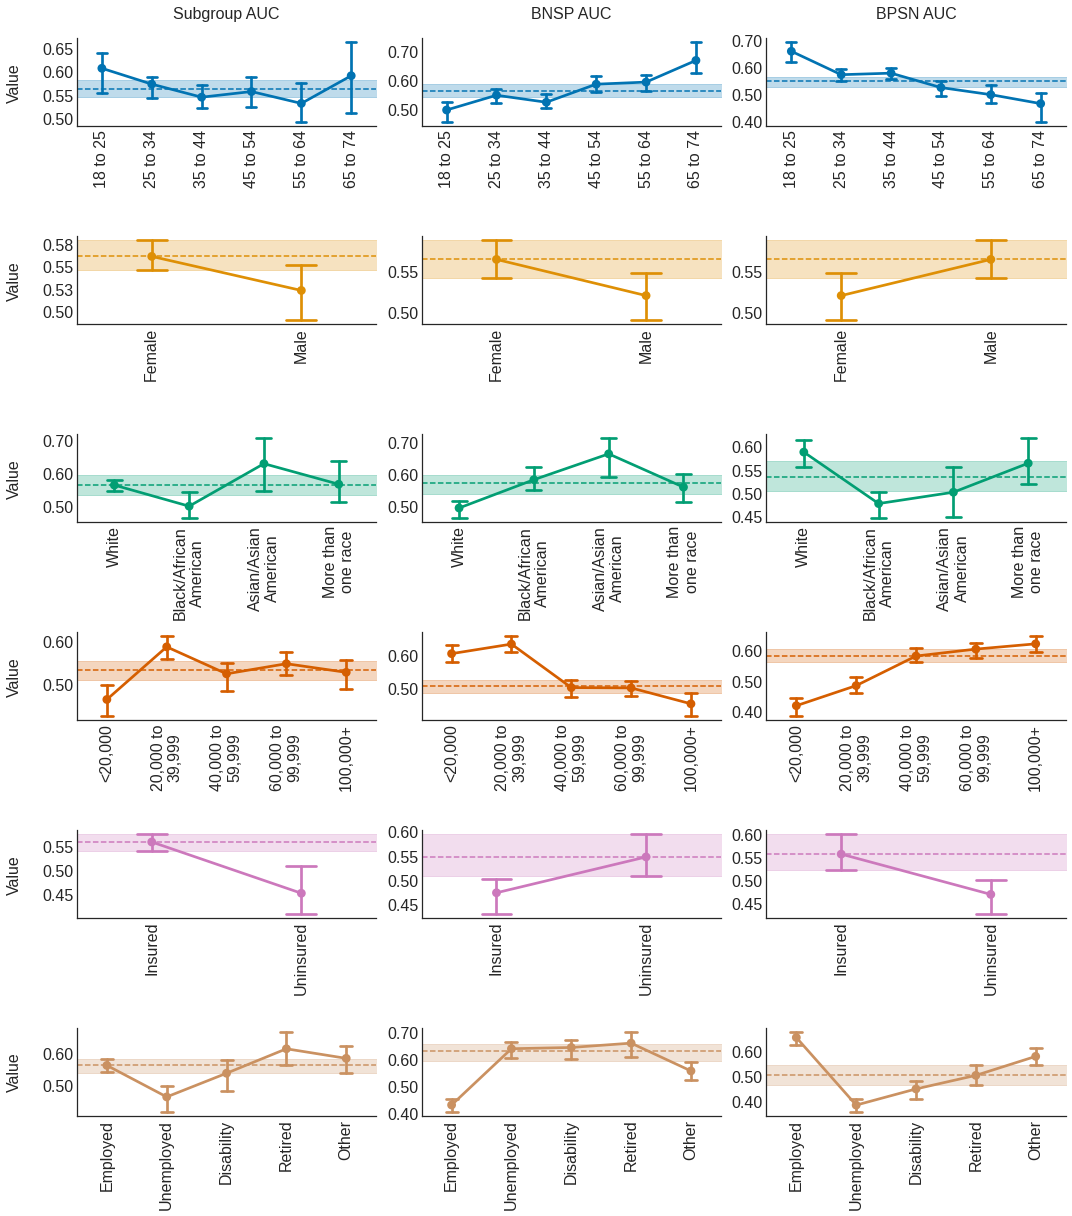

In [12]:
reload(reliability_analysis)

reliability_analysis.plot_auc_groups(
    res_df=res_df.loc[res_df.model_type == best_model_type, :],
    pred_df=best_pred_df,
    group_cols=lifesense_group_cols,
    group_map=group_map,
    order=lifesense_order,
    cv_type='lso',
    dataset='lifesense',
    training_col='Entire study',
)

plt.savefig(
    '../figs/figure_auroc_best_entire_study.png', 
    dpi=300, facecolor='white')

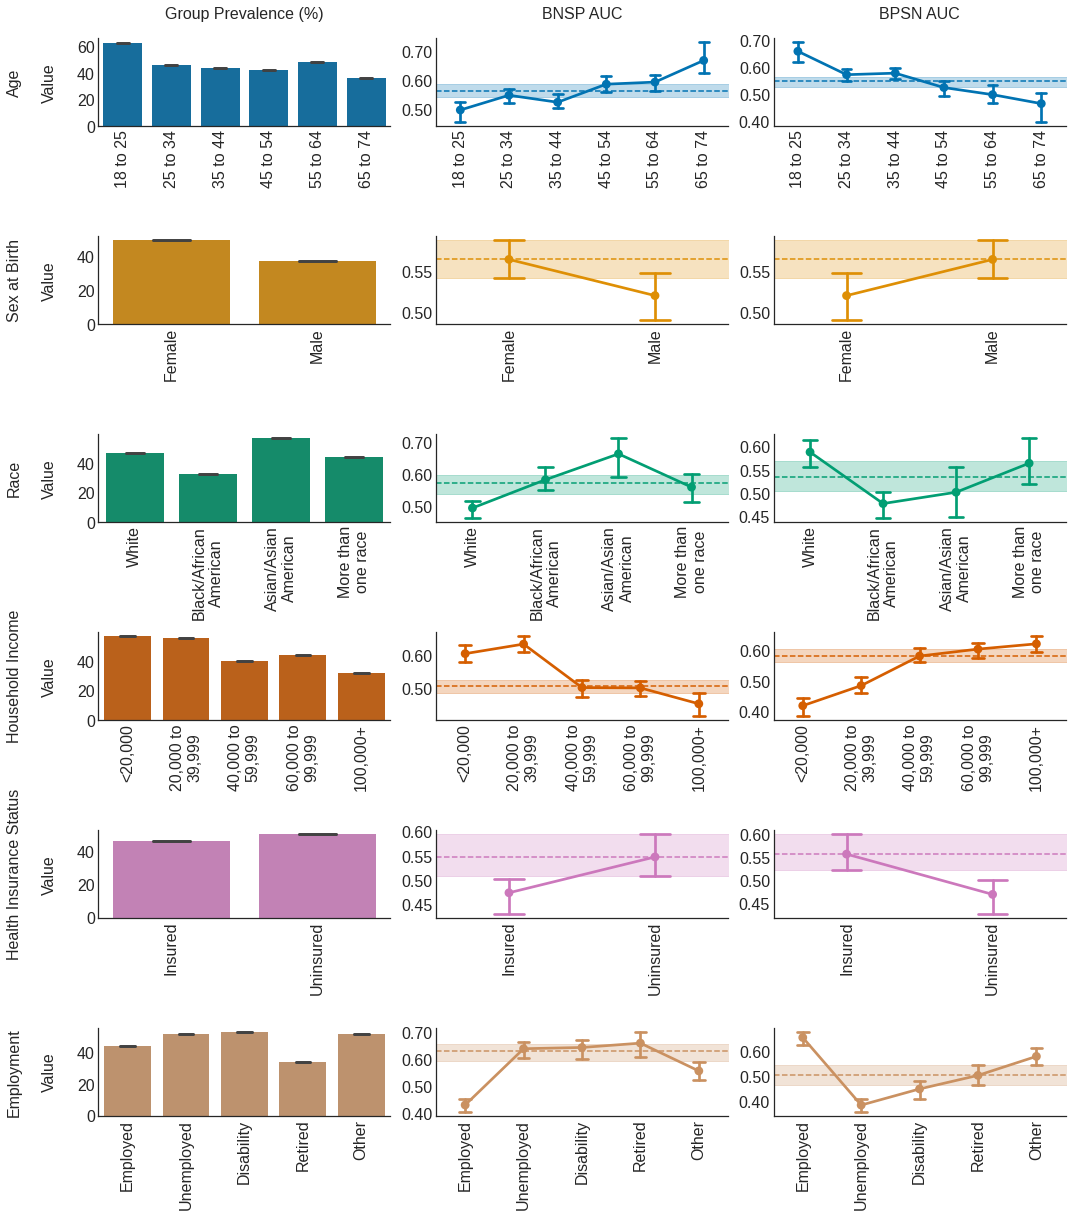

In [13]:
reload(reliability_analysis)
reliability_analysis.plot_auroc_w_prevalence(
    pred_df=best_pred_df, 
    res_df=res_df.loc[res_df.model_type == best_model_type, :], 
    cv_type='lso',
    group_cols=lifesense_group_cols, 
    order=lifesense_order, 
    group_map=group_map
)

plt.savefig(
    '../figs/figure_prevalence_auroc.png', 
    dpi=300, facecolor='white')

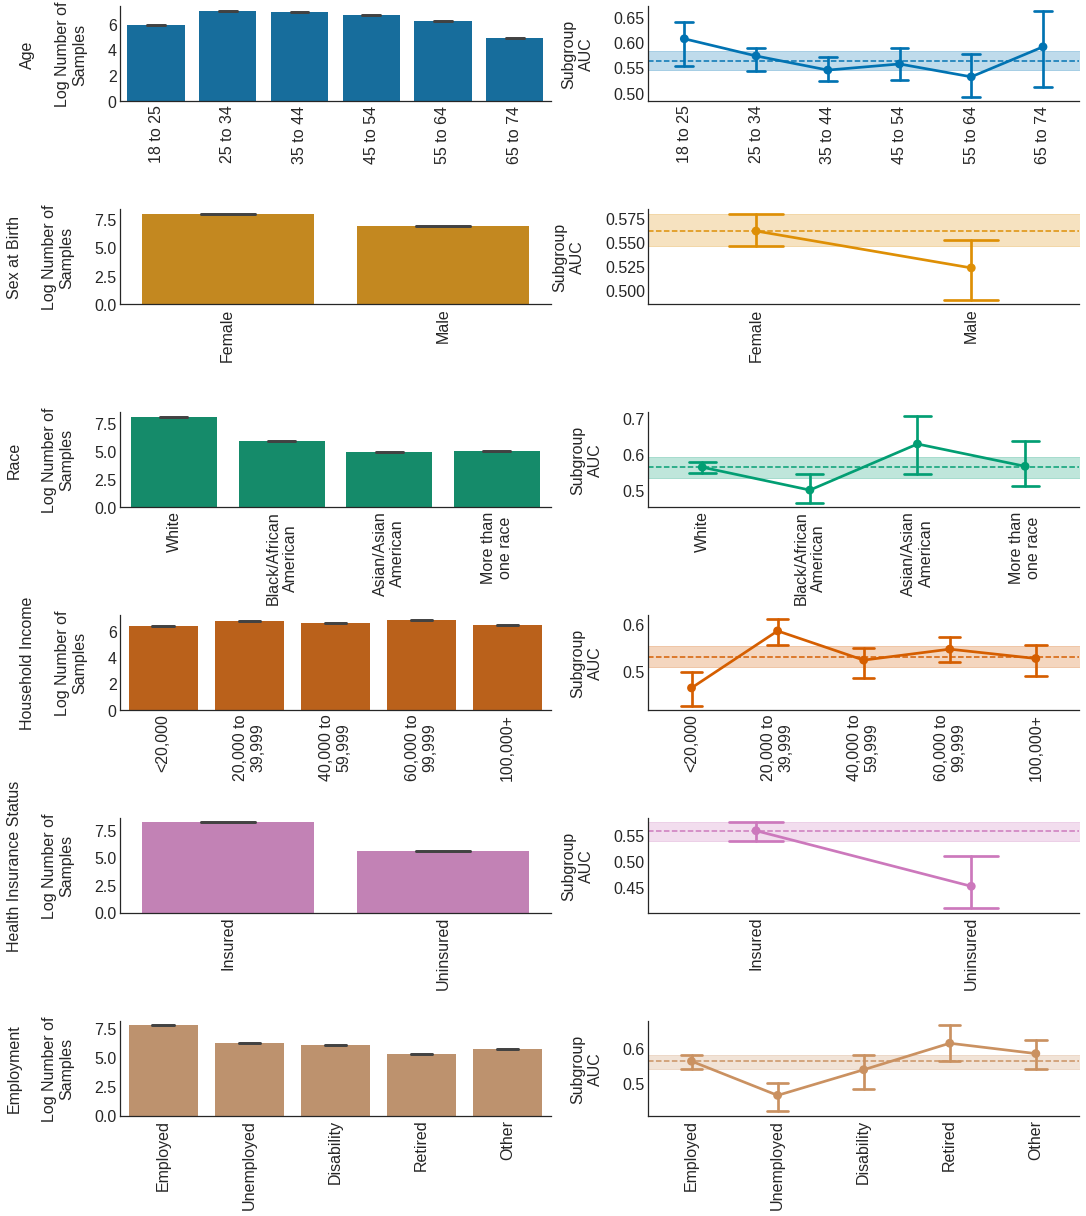

In [14]:
reload(reliability_analysis)
reliability_analysis.plot_auroc_w_samples(
    pred_df=best_pred_df, 
    res_df=res_df.loc[res_df.model_type == best_model_type, :], 
    cv_type='lso',
    group_cols=lifesense_group_cols, 
    order=lifesense_order, 
    group_map=group_map
)

plt.savefig(
    '../figs/figure_num_samples_w_auroc.png', 
    dpi=300, facecolor='white')

# LR Risk Shifts

In [15]:
reload(reliability_analysis)

lr_auc_df = reliability_analysis.lr_auc_groups_by_ground_truth(
    pred_df=best_pred_df,
    group_cols=lifesense_group_cols,
    group_map=group_map,
)

0 {'age': '18 to 25', 'demo_gender': 'Male', 'demo_race': 'White', 'demo_fam_income': '100,000+', 'demo_health_insurance': 'Insured', 'routine_slabels02': 'Employed'}
1 {'age': '65 to 74', 'demo_gender': 'Female', 'demo_race': 'Asian/Asian American', 'demo_fam_income': '20,000 to 39,999', 'demo_health_insurance': 'Insured', 'routine_slabels02': 'Retired'}


In [16]:
all_group_order = pd.DataFrame({'Group': [
        '18 to 25', '25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 to 74',
       'Female', 'Male',
       'White', 'Black/African American', 'Asian/Asian American', 'More than one race',
       '<20,000', '20,000 to 39,999', '40,000 to 59,999', '60,000 to 99,999', '100,000+',
       'Insured', 'Uninsured', 'Employed', 'Unemployed', 
       'Disability', 'Retired', 'Other']})

0
                     Group           β (95% CI)
0                 25 to 34  0.01 (-0.0 to 0.01)
1                 35 to 44  0.01 (0.01 to 0.02)
2                 45 to 54  0.02 (0.01 to 0.03)
3                 55 to 64  0.02 (0.01 to 0.03)
4                 65 to 74  0.02 (0.01 to 0.04)
5                   Female   0.0 (-0.0 to 0.01)
6   Black/African American   0.01 (0.0 to 0.01)
7     Asian/Asian American  0.02 (0.01 to 0.03)
8       More than one race  0.0 (-0.01 to 0.01)
9                  <20,000  0.02 (0.01 to 0.03)
10        20,000 to 39,999  0.01 (0.01 to 0.02)
11        40,000 to 59,999   0.01 (0.0 to 0.01)
12        60,000 to 99,999   0.0 (-0.0 to 0.01)
13               Uninsured  0.01 (-0.0 to 0.02)
14              Unemployed  0.03 (0.03 to 0.04)
15              Disability   0.01 (0.0 to 0.02)
16                 Retired  0.01 (-0.0 to 0.02)
17                   Other   0.0 (-0.0 to 0.01)



1
                     Group              β (95% CI)
0                 18 to 25  -0

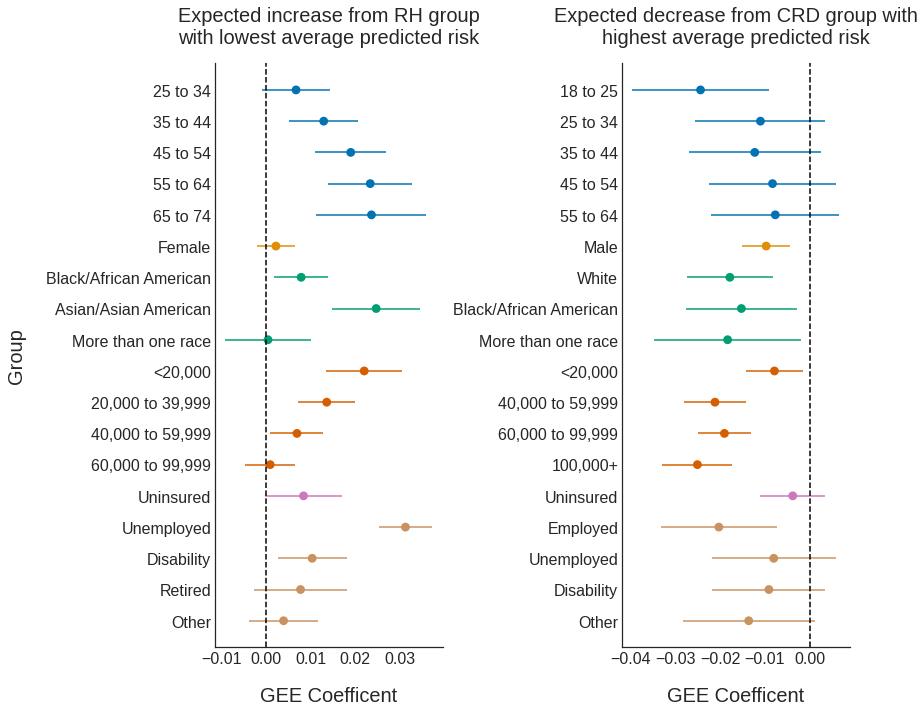

In [17]:
plt.figure(figsize=(12, 10))
curr = 1

colors = sns.color_palette(
    "colorblind", 
    n_colors=len(lifesense_group_cols)
)
color_map = dict(zip(lifesense_group_cols, colors))

for y in [0, 1]:
    
    plt.subplot(1, 2, curr)

    temp = lr_auc_df.loc[lr_auc_df['PHQ-8'] == y, :].copy()
    temp = pd.merge(left=all_group_order, right=temp, on=['Group'])
    colors = [color_map[temp.loc[ind, 'feature'].split('|')[0]] for ind in temp.index]
    ax = sns.pointplot(temp, y='Group', x='coef', join=False, palette=colors)
    low_err = temp['coef'] - temp['low']
    high_err = temp['high'] - temp['coef']
    plt.errorbar(
        x=temp['coef'], 
        y=range(temp.shape[0]), 
        xerr=[low_err, high_err],
        ecolor=colors,
        linestyle='',
    )

    print(y)
    print(temp[['Group', 'β (95% CI)']])
    print('\n\n')
    plt.axvline(0, ls='--', color='k')
    plt.xticks(size=16)
    plt.yticks(size=16)

    if y == 0:
        plt.ylabel('Group', size=20, labelpad=20)
    else:
        plt.ylabel('')

    plt.xlabel('GEE Coefficent', size=20, labelpad=20)

    if y == 0:
        plt.title(
            'Expected increase from RH group\n' +
            'with lowest average predicted risk',
            size=20,
            pad=20
        )
    else:
        plt.title(
            'Expected decrease from CRD group with\n' +
            'highest average predicted risk',
            size=20,
            pad=20
        )

    curr += 1

sns.despine()
plt.tight_layout()

plt.savefig(
    '../figs/figure_gee_group.png', 
    dpi=300, facecolor='white')

## SHAP

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

best_res_df = reliability_analysis.get_best_models(
    res_df=res_df.loc[res_df.model_type == best_model_type, :], 
    cv_type='lso', dataset='lifesense',
    training_col='Entire study'
)

train_sample = lifesense_df.copy()
features = lifesense_features[:]

# Impute and standardize
imp = IterativeImputer(max_iter=1000)
train_sample[features] = imp.fit_transform(train_sample[features])

# Standardize
sc = StandardScaler()
train_sample[features] = sc.fit_transform(train_sample[features])

m = best_res_df.loc[0, 'model_type']
p = eval(best_pred_df.loc[0, 'params'])

_, test_prob, _, test_pred, m, train, test  = reliability_analysis.ml_pipeline(
    model_type=m, params=p,
    train=train_sample, test=train_sample, 
    features=features
)

m = m.base_estimator.fit(train_sample[features], train_sample['y_binary'])

In [19]:
import shap

explainer = shap.TreeExplainer(
    m, train[features], 
    model_output='probability')
shap_values = explainer.shap_values(train[features])[1]

 99%|===================| 7752/7800 [02:30<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


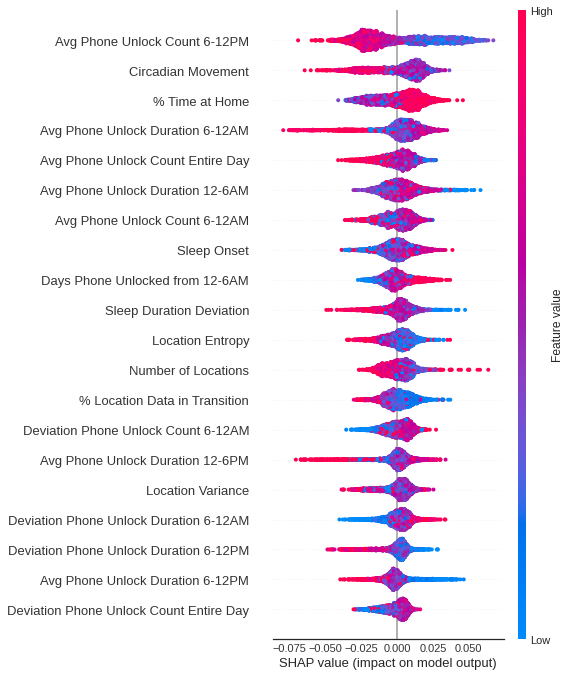

In [20]:
shap.summary_plot(
    shap_values, train[features], 
    feature_names=[lifesense_features_dict[f] for f in features], 
    sort=True
)

# Behavior Regression Analysis

In [21]:
reload(reliability_analysis)
lr_df_with_group = reliability_analysis.feature_lr_with_group(
    df=lifesense_df, features=lifesense_features, 
    group_cols=lifesense_group_cols
)

In [22]:
def get_multiple_sig(
    df, col, num_sig, 
    feature_titles, order, group_names
):

    coef_col = 'lr_coef'
    sig_col = 'lr_bonf_sig'
    pvalue_col = 'lr_pvalue'
    low_col = 'lr_low'
    high_col = 'lr_high'
    med_col = 'median'
    low_pct_col = 'low_95'
    high_pct_col = 'high_95'

    df = df.copy()
    # Filter to col
    df = df.loc[df.column == col, :]
    # Filter to features that are below 0
    df = df.loc[
        ((df[coef_col] < 0) & (df[high_col] < 0)) |
        ((df[coef_col] > 0) & (df[low_col] > 0)), : 
    ]
    f = df.groupby(['column', 'feature'], as_index=False)[sig_col].sum()
    f = f.loc[f[sig_col] >= num_sig, 'feature'].values
    
    df_filtered = df.loc[
        df.feature.isin(f) & (df[sig_col] == 1), 
        ['value', 'feature', 
        coef_col, low_col, high_col, 
        med_col, low_pct_col, high_pct_col,
        pvalue_col]]
    df_filtered['feature'] = df_filtered['feature'].map(feature_titles)
    df_filtered[coef_col] = [
        str(np.round(df_filtered.loc[i, coef_col], 2)) + \
        ' (' + str(np.round(df_filtered.loc[i, low_col], 2)) + \
            ' to ' + str(np.round(df_filtered.loc[i, high_col], 2))  + ')' \
                for i in df_filtered.index]
    df_filtered[med_col] = [
        str(np.round(df_filtered.loc[i, med_col], 2)) + \
        ' (' + str(np.round(df_filtered.loc[i, low_pct_col], 2)) + \
            ' to ' + str(np.round(df_filtered.loc[i, high_pct_col], 2))  + ')' \
                for i in df_filtered.index]
    
    df_filtered = pd.merge(
        left=pd.DataFrame({'value': order[col]}),
        right=df_filtered
    )
    df_filtered[pvalue_col] = df_filtered[pvalue_col].round(3)
    df_filtered = df_filtered[[
        'value', 'feature', coef_col, med_col]]
    df_filtered.columns = [
        group_names[col], 
        'Behavioral Feature', 'β (95% CI)', 
        'Median (95% CI)']
    print('alpha_bonf=', df['alpha_bonf'].unique())
    return df_filtered.sort_values(by=['Behavioral Feature'])

In [23]:
get_multiple_sig(
    df=lr_df_with_group, 
    col='age', 
    num_sig=2,
    feature_titles=lifesense_features_dict,
    order=lifesense_order,
    group_names=group_map
)

alpha_bonf= [0.00833333]


,Age,Behavioral Feature,β (95% CI),Median (95% CI)
18,65 to 74,Avg Phone Unlock Count 12-6PM,0.68 (0.14 to 1.22),-0.79 (-2.55 to 0.37)
4,25 to 34,Avg Phone Unlock Count 12-6PM,-0.21 (-0.33 to -0.09),0.38 (-2.69 to 1.63)
17,65 to 74,Avg Phone Unlock Count 6-12PM,0.6 (0.07 to 1.12),-0.62 (-1.96 to 0.76)
0,18 to 25,Avg Phone Unlock Count 6-12PM,-0.77 (-1.07 to -0.47),0.32 (-2.27 to 1.6)
3,25 to 34,Avg Phone Unlock Count 6-12PM,-0.24 (-0.36 to -0.12),0.18 (-2.27 to 1.86)
2,25 to 34,Avg Phone Unlock Count Entire Day,-0.17 (-0.29 to -0.06),0.37 (-2.71 to 1.56)
16,65 to 74,Avg Phone Unlock Count Entire Day,0.74 (0.19 to 1.29),-0.68 (-2.39 to 0.38)
13,65 to 74,Avg Phone Unlock Duration 6-12AM,0.59 (0.17 to 1.01),0.04 (-2.68 to 1.57)
9,45 to 54,Avg Phone Unlock Duration 6-12AM,-0.4 (-0.59 to -0.22),0.03 (-2.12 to 2.2)
8,45 to 54,Avg Phone Unlock Duration Entire Day,-0.3 (-0.48 to -0.12),0.1 (-2.23 to 1.92)


In [24]:
get_multiple_sig(
    df=lr_df_with_group, 
    col='demo_gender', 
    num_sig=2,
    feature_titles=lifesense_features_dict,
    order=lifesense_order,
    group_names=group_map
)

alpha_bonf= [0.025]


,Sex at Birth,Behavioral Feature,β (95% CI),Median (95% CI)
0,Female,Avg Phone Unlock Count Entire Day,-0.1 (-0.18 to -0.03),0.18 (-2.6 to 1.51)
3,Male,Avg Phone Unlock Count Entire Day,0.16 (0.01 to 0.3),0.15 (-2.84 to 1.71)
2,Female,Days Phone Unlocked from 12-6AM,0.12 (0.05 to 0.19),0.06 (-1.92 to 1.26)
5,Male,Days Phone Unlocked from 12-6AM,0.3 (0.15 to 0.46),0.27 (-1.92 to 1.26)
1,Female,Deviation Phone Unlock Count 12-6PM,-0.1 (-0.17 to -0.02),0.07 (-2.24 to 1.77)
4,Male,Deviation Phone Unlock Count 12-6PM,0.18 (0.04 to 0.32),0.03 (-2.84 to 1.73)


In [25]:
get_multiple_sig(
    df=lr_df_with_group, 
    col='demo_race', 
    num_sig=2,
    feature_titles=lifesense_features_dict,
    order=lifesense_order,
    group_names=group_map
)

alpha_bonf= [0.0125]


,Race,Behavioral Feature,β (95% CI),Median (95% CI)
4,Asian/Asian American,Avg Phone Unlock Count 12-6PM,-1.06 (-1.62 to -0.5),0.23 (-1.81 to 1.14)
7,More than one race,Avg Phone Unlock Count 12-6PM,-0.53 (-0.9 to -0.15),0.18 (-2.1 to 1.69)
1,White,Avg Phone Unlock Count 6-12PM,-0.11 (-0.18 to -0.04),0.06 (-2.16 to 1.8)
3,Asian/Asian American,Avg Phone Unlock Count 6-12PM,-1.56 (-2.23 to -0.89),-0.07 (-2.23 to 1.09)
2,Asian/Asian American,Avg Phone Unlock Count Entire Day,-0.91 (-1.51 to -0.31),0.2 (-1.94 to 1.05)
6,More than one race,Avg Phone Unlock Count Entire Day,-0.47 (-0.84 to -0.1),0.23 (-2.7 to 1.73)
0,White,Deviation Phone Unlock Duration 6-12PM,-0.09 (-0.16 to -0.02),-0.13 (-1.61 to 2.78)
5,More than one race,Deviation Phone Unlock Duration 6-12PM,0.52 (0.05 to 1.0),0.0 (-1.05 to 2.21)


In [26]:
get_multiple_sig(
    df=lr_df_with_group, 
    col='demo_fam_income', 
    num_sig=2,
    feature_titles=lifesense_features_dict,
    order=lifesense_order,
    group_names=group_map
)

alpha_bonf= [0.01]


,Household Income,Behavioral Feature,β (95% CI),Median (95% CI)
4,"<20,000",% Time at Home,-0.3 (-0.52 to -0.08),0.44 (-3.97 to 0.83)
10,"60,000 to 99,999",% Time at Home,0.42 (0.26 to 0.58),0.18 (-2.8 to 0.82)
5,"40,000 to 59,999",Avg Phone Unlock Count 12-6AM,-0.3 (-0.51 to -0.08),-0.17 (-1.12 to 2.02)
11,"100,000+",Avg Phone Unlock Count 12-6AM,0.41 (0.17 to 0.65),-0.38 (-1.71 to 1.9)
3,"<20,000",Circadian Movement,0.3 (0.09 to 0.51),-0.19 (-2.65 to 1.67)
9,"60,000 to 99,999",Circadian Movement,-0.21 (-0.35 to -0.07),0.29 (-1.89 to 1.82)
0,"<20,000",Location Entropy,0.35 (0.14 to 0.57),-0.37 (-1.21 to 2.87)
6,"60,000 to 99,999",Location Entropy,-0.34 (-0.48 to -0.2),0.04 (-1.17 to 2.28)
1,"<20,000",Location Normalized Entropy,0.36 (0.14 to 0.58),-0.19 (-1.28 to 2.95)
7,"60,000 to 99,999",Location Normalized Entropy,-0.33 (-0.48 to -0.18),0.04 (-1.23 to 2.08)


In [27]:
get_multiple_sig(
    df=lr_df_with_group, 
    col='demo_health_insurance', 
    num_sig=2,
    feature_titles=lifesense_features_dict,
    order=lifesense_order,
    group_names=group_map
)

alpha_bonf= [0.025]


,Health Insurance Status,Behavioral Feature,β (95% CI),Median (95% CI)
1,Insured,% Location Data in Transition,-0.15 (-0.22 to -0.08),-0.26 (-1.11 to 2.44)
6,Uninsured,% Location Data in Transition,0.32 (0.11 to 0.52),-0.16 (-1.1 to 4.44)
0,Insured,% Time at Home,0.18 (0.11 to 0.25),0.36 (-2.86 to 0.83)
5,Uninsured,% Time at Home,-0.26 (-0.46 to -0.06),0.13 (-3.97 to 0.82)
3,Insured,Avg Phone Unlock Count 12-6PM,-0.08 (-0.14 to -0.01),0.11 (-2.36 to 1.66)
8,Uninsured,Avg Phone Unlock Count 12-6PM,0.31 (0.04 to 0.57),0.19 (-2.26 to 1.99)
2,Insured,Avg Phone Unlock Count 6-12PM,-0.18 (-0.24 to -0.11),0.09 (-2.18 to 1.82)
7,Uninsured,Avg Phone Unlock Count 6-12PM,0.31 (0.06 to 0.56),-0.13 (-2.15 to 2.18)
4,Insured,Deviation Phone Unlock Count 6-12PM,-0.1 (-0.17 to -0.03),0.06 (-2.29 to 1.82)
9,Uninsured,Deviation Phone Unlock Count 6-12PM,0.29 (0.04 to 0.55),0.04 (-2.09 to 1.85)


In [28]:
get_multiple_sig(
    df=lr_df_with_group, 
    col='routine_slabels02', 
    num_sig=2,
    feature_titles=lifesense_features_dict,
    order=lifesense_order,
    group_names=group_map
)

alpha_bonf= [0.01]


,Employment,Behavioral Feature,β (95% CI),Median (95% CI)
17,Disability,Avg Phone Unlock Count 12-6AM,-0.22 (-0.44 to -0.01),-0.14 (-1.71 to 2.27)
23,Retired,Avg Phone Unlock Count 12-6AM,1.05 (0.55 to 1.56),-0.52 (-1.15 to 1.05)
4,Employed,Avg Phone Unlock Count 12-6AM,0.15 (0.06 to 0.23),-0.22 (-1.12 to 2.15)
27,Other,Avg Phone Unlock Duration 12-6AM,-0.39 (-0.65 to -0.13),-0.04 (-2.25 to 1.56)
12,Disability,Avg Phone Unlock Duration 12-6AM,-0.57 (-0.82 to -0.33),0.25 (-2.21 to 1.77)
20,Retired,Avg Phone Unlock Duration 12-6AM,0.59 (0.24 to 0.95),-0.01 (-2.21 to 1.21)
14,Disability,Avg Phone Unlock Duration 6-12AM,-0.33 (-0.55 to -0.12),0.19 (-2.32 to 1.74)
28,Other,Avg Phone Unlock Duration 6-12AM,-0.54 (-0.86 to -0.21),0.07 (-1.7 to 1.66)
13,Disability,Avg Phone Unlock Duration 6-12PM,-0.51 (-0.75 to -0.27),0.13 (-2.48 to 1.79)
21,Retired,Avg Phone Unlock Duration 6-12PM,0.38 (0.06 to 0.7),0.11 (-2.16 to 1.88)


# ROC All Models Analysis

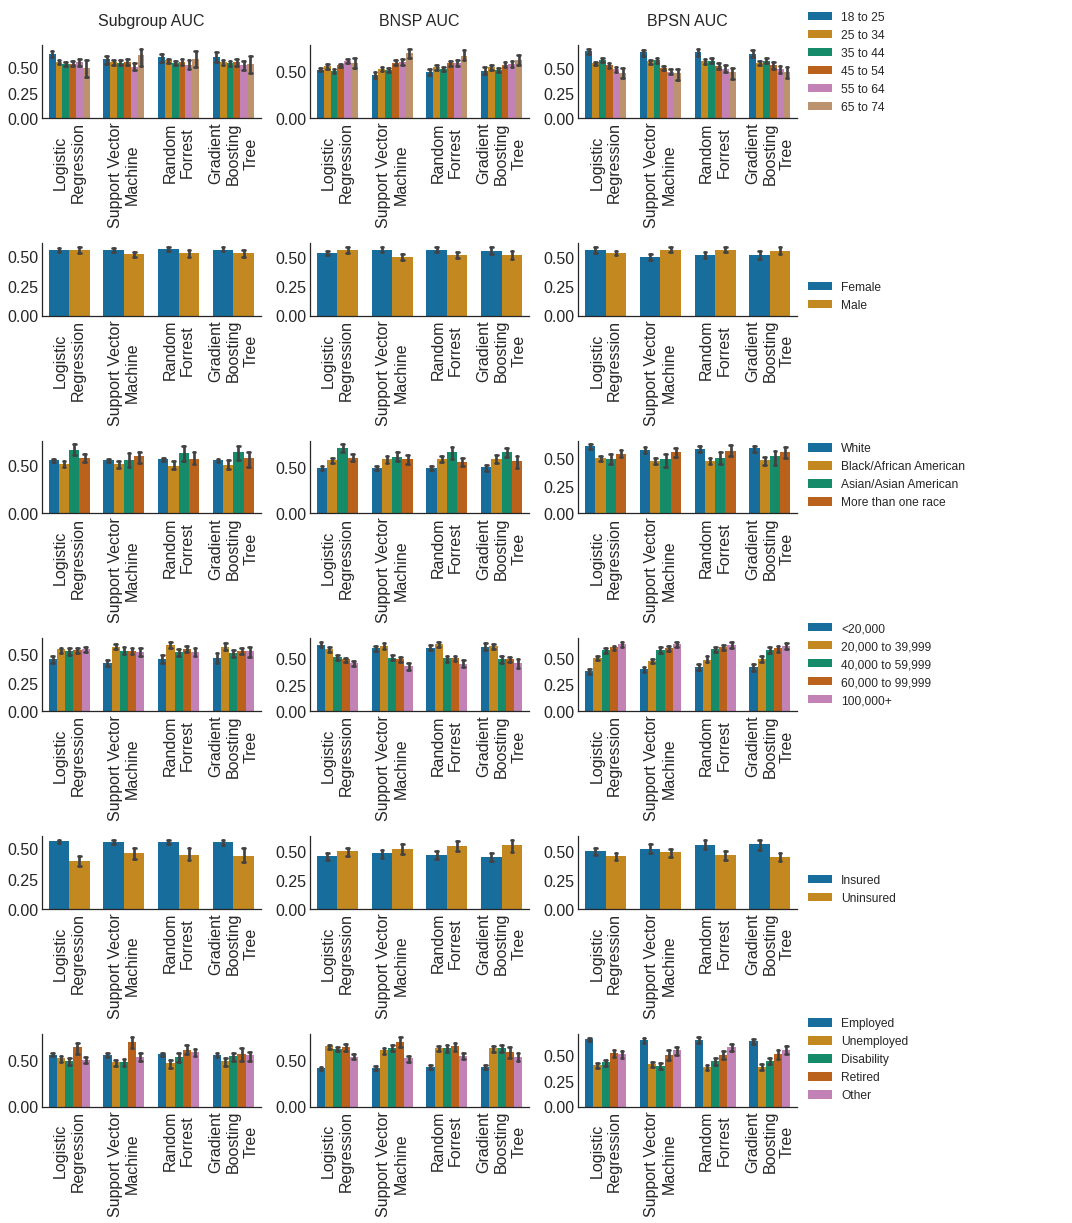

In [29]:
reload(reliability_analysis)

reliability_analysis.plot_auc_groups_by_model_type(
    res_df=res_df,
    group_cols=lifesense_group_cols,
    group_map=group_map,
    order=lifesense_order,
    cv_type='lso',
    dataset='lifesense',
    training_col='Entire study',
)

plt.savefig(
    '../figs/figure_auroc_by_model_entire_study.png', 
    dpi=300, facecolor='white')

# Group Histograms

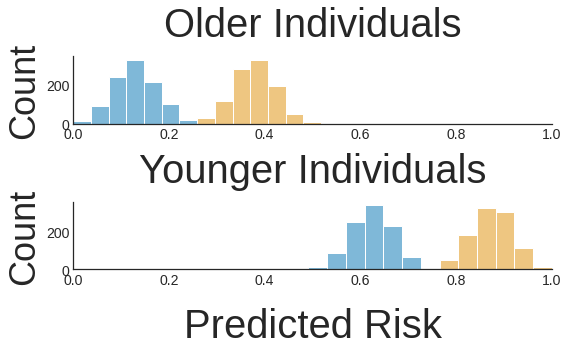

In [30]:
s = 1000

a_neg = np.random.normal(loc=0.0, scale=0.35, size=s)
a_pos = np.random.normal(loc=2.0, scale=0.35, size=s)

b_neg = np.random.normal(loc=4.0, scale=0.35, size=s)
b_pos = np.random.normal(loc=6, scale=0.35, size=s)

hist_df = pd.DataFrame({
    'group': ['Group A'] * (s * 2) + ['Group B'] * (s * 2),
    'outcome': ['PHQ-8 <10'] * s + \
        ['PHQ-8 ≥10'] * s + ['PHQ-8 <10'] * s + ['PHQ-8 ≥10'] * s,
    'data': list(a_neg) + list(a_pos) + list(b_neg) + list(b_pos)
})
hist_df['data'] = (hist_df['data'] - hist_df['data'].min()) / \
    (hist_df['data'].max() - hist_df['data'].min())

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
ax = sns.histplot(
    hist_df.loc[hist_df.group == 'Group A', :], x='data', 
    hue='outcome',
    palette='colorblind'
)
plt.xlim(hist_df.data.min(), hist_df.data.max())
plt.title('Older Individuals', size=40, pad=20)
plt.xticks(size=14)
plt.xlabel('')
plt.ylabel('Count', size=36)
plt.yticks(size=14)
ax.get_legend().remove()

plt.subplot(2, 1, 2)
ax = sns.histplot(
    hist_df.loc[hist_df.group == 'Group B', :], 
    x='data', hue='outcome',
    palette='colorblind'
)
plt.xlim(hist_df.data.min(), hist_df.data.max())
plt.title('Younger Individuals', size=40, pad=20)
plt.xticks(size=14)
plt.xlabel('Predicted Risk', size=40, labelpad=20)
plt.ylabel('Count', size=36)
plt.yticks(size=14)
ax.get_legend().remove()

plt.tight_layout()
sns.despine()

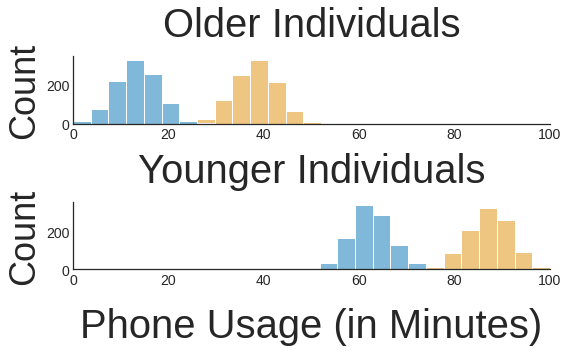

In [31]:
s = 1000

a_neg = np.random.normal(loc=0.0, scale=0.35, size=s)
a_pos = np.random.normal(loc=2.0, scale=0.35, size=s)

b_neg = np.random.normal(loc=4.0, scale=0.35, size=s)
b_pos = np.random.normal(loc=6, scale=0.35, size=s)

hist_df = pd.DataFrame({
    'group': ['Group A'] * (s * 2) + ['Group B'] * (s * 2),
    'outcome': ['PHQ-8 <10'] * s + \
        ['PHQ-8 ≥10'] * s + ['PHQ-8 <10'] * s + ['PHQ-8 ≥10'] * s,
    'data': list(a_neg) + list(a_pos) + list(b_neg) + list(b_pos)
})
hist_df['data'] = 100 * (hist_df['data'] - hist_df['data'].min()) / \
    (hist_df['data'].max() - hist_df['data'].min())

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
ax = sns.histplot(
    hist_df.loc[hist_df.group == 'Group A', :], x='data', 
    hue='outcome',
    palette='colorblind'
)
plt.xlim(hist_df.data.min(), hist_df.data.max())
plt.title('Older Individuals', size=40, pad=20)
plt.xticks(size=14)
plt.xlabel('')
plt.ylabel('Count', size=36)
plt.yticks(size=14)
ax.get_legend().remove()

plt.subplot(2, 1, 2)
ax = sns.histplot(
    hist_df.loc[hist_df.group == 'Group B', :], 
    x='data', hue='outcome',
    palette='colorblind'
)
plt.xlim(hist_df.data.min(), hist_df.data.max())
plt.title('Younger Individuals', size=40, pad=20)
plt.xticks(size=14)
plt.xlabel('Phone Usage (in Minutes)', size=40, labelpad=20)
plt.ylabel('Count', size=36)
plt.yticks(size=14)
ax.get_legend().remove()

plt.tight_layout()
sns.despine()

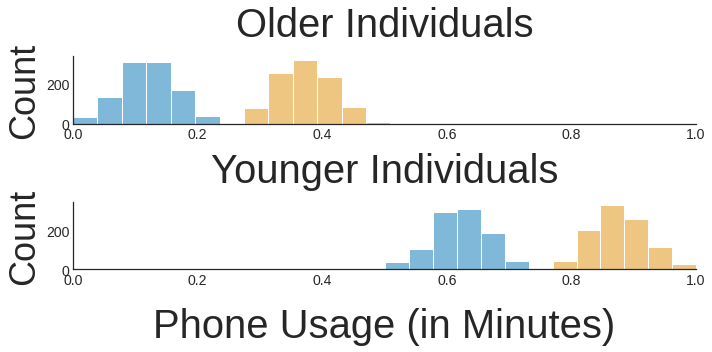

In [32]:
s = 1000

from sklearn.metrics import roc_auc_score

a_neg = np.random.normal(loc=0.0, scale=0.35, size=s)
a_pos = np.random.normal(loc=2.0, scale=0.35, size=s)

b_neg = np.random.normal(loc=4.0, scale=0.35, size=s)
b_pos = np.random.normal(loc=6, scale=0.35, size=s)


hist_df = pd.DataFrame({
    'group': ['Group A'] * (s * 2) + ['Group B'] * (s * 2),
    'outcome': ['PHQ-8 <10'] * s + \
        ['PHQ-8 ≥10'] * s + ['PHQ-8 <10'] * s + ['PHQ-8 ≥10'] * s,
    'data': list(a_neg) + list(a_pos) + list(b_neg) + list(b_pos)
})
hist_df['data'] = (hist_df['data'] - hist_df['data'].min()) / \
    (hist_df['data'].max() - hist_df['data'].min())

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
ax = sns.histplot(
    hist_df.loc[hist_df.group == 'Group A', :], x='data', 
    hue='outcome',
    palette='colorblind'
)
plt.xlim(hist_df.data.min(), hist_df.data.max())
plt.title('Older Individuals', size=40, pad=20)
plt.xticks(size=14)
plt.xlabel('')
plt.ylabel('Count', size=36)
plt.yticks(size=14)
ax.get_legend().remove()

plt.subplot(2, 1, 2)
ax = sns.histplot(
    hist_df.loc[hist_df.group == 'Group B', :], 
    x='data', hue='outcome',
    palette='colorblind'
)
plt.xlim(hist_df.data.min(), hist_df.data.max())
plt.title('Younger Individuals', size=40, pad=20)
plt.xticks(size=14)
plt.xlabel('Phone Usage (in Minutes)', size=40, labelpad=20)
plt.ylabel('Count', size=36)
plt.yticks(size=14)
ax.get_legend().remove()

plt.tight_layout()
sns.despine()